Task 1 - Time Series Prediction

Prediction on GA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")



In [10]:
df = pd.read_csv('data/cleaned/ga_hta_ts.csv')
df.set_index('postcode', inplace=True)
# Do GA here!
df = df[df['type'] == 'ga']

feature_cols = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
target_cols = ['2023', '2024']
df[feature_cols + target_cols] = df[feature_cols + target_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=feature_cols + target_cols, inplace=True)

train_df = df[~df['region'].isin(['Southwest', 'Central'])].copy()
test_df = df[df['region'].isin(['Southwest', 'Central'])].copy()

In [11]:
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_cols].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_cols].values.astype(np.float32)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [50]:
# ARIMA

# for testing
orders = [
    (1, 0, 1),
    (2, 0, 1),
    (2, 1, 0),
    (2, 1, 1),
    (3, 1, 0),
]

# best is (2, 1, 0)
for order in [(2, 1, 0)]:
    arima_preds = []
    for row in X_test:
        model = ARIMA(row, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=2)
        arima_preds.append(forecast)
    arima_preds = np.array(arima_preds)
    print("Predicting ", order)
    print(np.sqrt(mean_squared_error(y_test, arima_preds)))

Predicting  (2, 1, 0)
22.08026005802901


In [53]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

X_train_seq = torch.tensor(X_train_scaled[:, :, None])
y_train_seq = torch.tensor(y_train_scaled)
X_test_seq = torch.tensor(X_test_scaled[:, :, None])
y_test_seq = torch.tensor(y_test_scaled)

train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=8, shuffle=True, generator=torch.Generator().manual_seed(88))

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(150):
    if epoch % 15 == 0:
        print(epoch)
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
model.eval()

lstm_preds = scaler_y.inverse_transform(model(X_test_seq).detach().numpy())
print(np.sqrt(mean_squared_error(y_test, lstm_preds)))

0
15
30
45
60
75
90
105
120
135
14.727735364435489


In [43]:
class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(1, 4)
        encoder_layer = nn.TransformerEncoderLayer(d_model=4, nhead=4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(4, 2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])

model_t = TransformerModel()
optimizer_t = torch.optim.Adam(model_t.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=8, shuffle=True, generator=torch.Generator().manual_seed(88))

for epoch in range(150):
    if epoch % 15 == 0:
        print(epoch)
    model_t.train()
    for xb, yb in train_loader:
        optimizer_t.zero_grad()
        preds = model_t(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_t.step()

model_t.eval()
transformer_preds = scaler_y.inverse_transform(model_t(X_test_seq).detach().numpy())
print(np.sqrt(mean_squared_error(y_test, transformer_preds)))

0
15
30
45
60
75
90
105
120
135
19.290677775118155


In [48]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=16, num_layers=2, batch_first=True)
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

model_g = GRUModel()
optimizer_g = torch.optim.Adam(model_g.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=8, shuffle=True, generator=torch.Generator().manual_seed(88))

for epoch in range(150):
    if epoch % 15 == 0:
        print(epoch)
    model_g.train()
    for xb, yb in train_loader:
        optimizer_g.zero_grad()
        preds = model_g(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_g.step()

model_g.eval()
gru_preds = scaler_y.inverse_transform(model_g(X_test_seq).detach().numpy())
print(np.sqrt(mean_squared_error(y_test, gru_preds)))

0
15
30
45
60
75
90
105
120
135
14.909832346003677


In [51]:
# set back the best architecture config before preds for final run

mse = {
    "ARIMA": mean_squared_error(y_test, arima_preds),
    "LSTM": mean_squared_error(y_test, lstm_preds),
    "Transformer": mean_squared_error(y_test, transformer_preds),
    "GRU": mean_squared_error(y_test, gru_preds)
}
rmse = {
    "ARIMA": np.sqrt(mean_squared_error(y_test, arima_preds)),
    "LSTM": np.sqrt(mean_squared_error(y_test, lstm_preds)),
    "Transformer": np.sqrt(mean_squared_error(y_test, transformer_preds)),
    "GRU": np.sqrt(mean_squared_error(y_test, gru_preds))
}
print("MSE scores:", mse)
print("RMSE scores:", rmse)

MSE scores: {'ARIMA': 487.53788423019114, 'LSTM': 210.23451232910156, 'Transformer': 372.1302490234375, 'GRU': 222.3031005859375}
RMSE scores: {'ARIMA': np.float64(22.08026005802901), 'LSTM': np.float64(14.499465932547363), 'Transformer': np.float64(19.290677775118155), 'GRU': np.float64(14.909832346003677)}


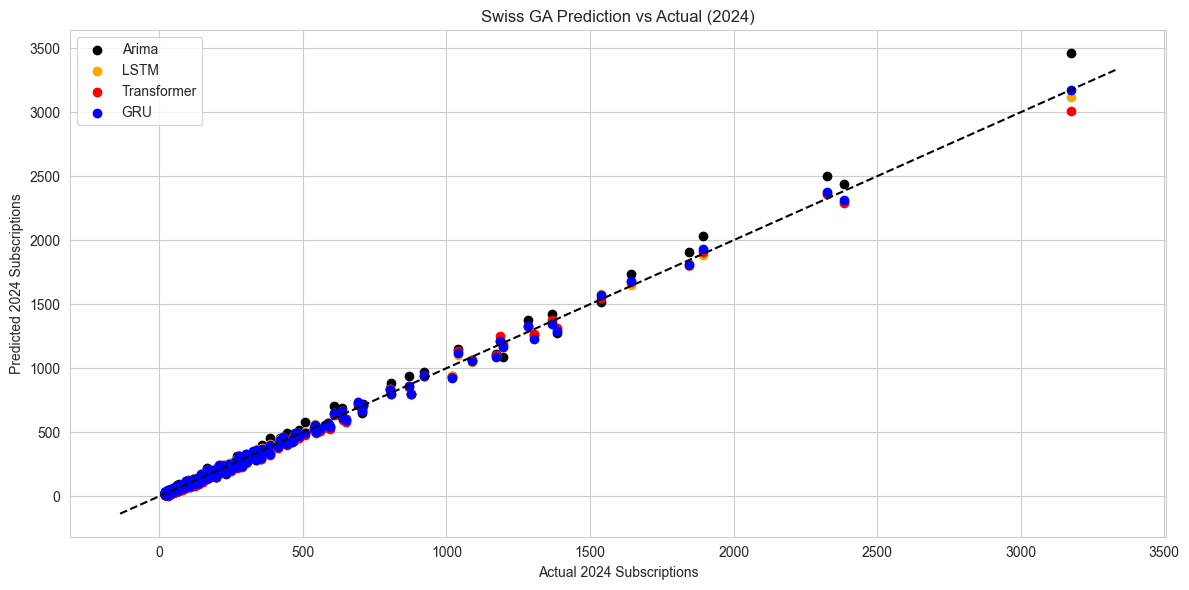

In [52]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 1], arima_preds[:, 1], label='Arima', marker='o', color='black')
plt.scatter(y_test[:, 1], lstm_preds[:, 1], label='LSTM', marker='o', color='orange')
plt.scatter(y_test[:, 1], transformer_preds[:, 1], label='Transformer', marker='o', color='red')
plt.scatter(y_test[:, 1], gru_preds[:, 1], label='GRU', marker='o', color='blue')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k')

plt.legend()
plt.title("Swiss GA Prediction vs Actual (2024)")
plt.xlabel("Actual 2024 Subscriptions")
plt.ylabel("Predicted 2024 Subscriptions")
plt.grid(True)
plt.tight_layout()
plt.show()